In [9]:
from utilities import *

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [2]:
dataset = load_dataset("Train")

Loaded 100 subjects


In [3]:
X,y = create_features_matrix(dataset, category=True, dataframe=False)

Creating features matrix


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


In [4]:
X.shape

(100, 35)

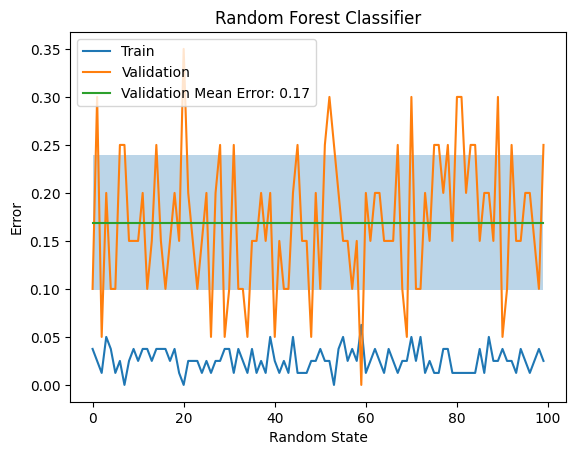

In [5]:
K = 100
N_ESTIMATORS = 100
MAX_DEPTH = 7
MAX_FEATURES="sqrt"
MIN_SAMPLES_SPLIT=5 
MIN_SAMPLES_LEAF=3

train_errors = []
val_errors = []
for i in range(K):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=i)
    model = RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH,max_features=MAX_FEATURES, min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=MIN_SAMPLES_LEAF,random_state=0)
    model.fit(X_train, y_train)
    train_errors.append(1 - model.score(X_train, y_train))
    val_errors.append(1 - model.score(X_val, y_val))

mean_val_error = np.mean(val_errors)
std_val_error = np.std(val_errors)
fig = plt.figure()
plt.plot(range(K), train_errors, label="Train")
plt.plot(range(K), val_errors, label="Validation")
plt.plot(range(K), [mean_val_error]*K, label=f"Validation Mean Error: {mean_val_error:.2f}")
plt.fill_between(range(K), [mean_val_error-std_val_error]*K, [mean_val_error+std_val_error]*K, alpha=0.3)
plt.title("Random Forest Classifier")
plt.xlabel("Random State")
plt.ylabel("Error")
plt.legend()
plt.show()

In [6]:
clf = RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH,max_features=MAX_FEATURES, min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=MIN_SAMPLES_LEAF,random_state=0)
clf.fit(X, y)
print(clf.score(X, y))

0.97


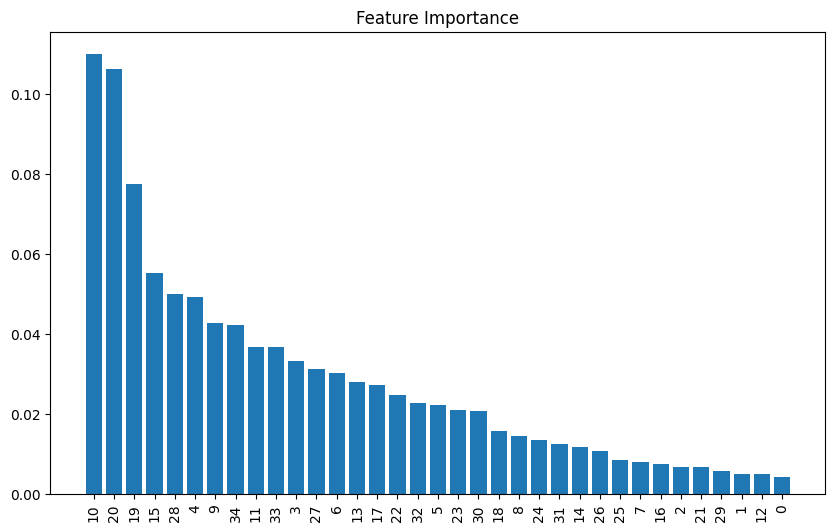

In [7]:
importances = clf.feature_importances_

index = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[index], align="center")
plt.xticks(range(len(importances)),index, rotation=90)
plt.show()

In [10]:
pca = PCA(n_components=5) 
X_pca = pca.fit_transform(X)

print(f"Var explained : {sum(pca.explained_variance_ratio_):.2f}")

Var explained : 1.00


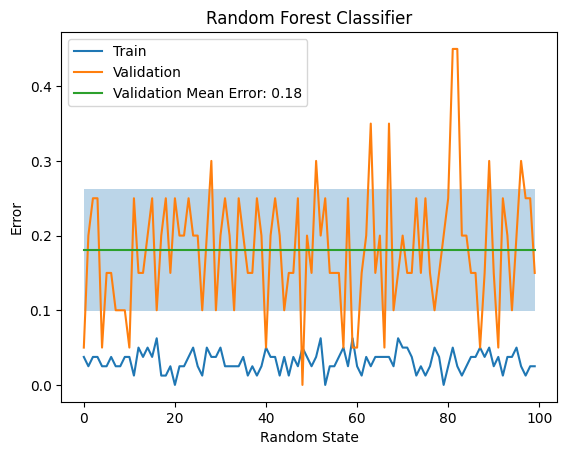

In [11]:
K = 100
N_ESTIMATORS = 100
MAX_DEPTH = 10
MAX_FEATURES="sqrt"
MIN_SAMPLES_SPLIT=5 
MIN_SAMPLES_LEAF=3

train_errors = []
val_errors = []
for i in range(K):
    X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.2, random_state=i)
    model = RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH,max_features=MAX_FEATURES, min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=MIN_SAMPLES_LEAF,random_state=0)
    model.fit(X_train, y_train)
    train_errors.append(1 - model.score(X_train, y_train))
    val_errors.append(1 - model.score(X_val, y_val))

mean_val_error = np.mean(val_errors)
std_val_error = np.std(val_errors)
fig = plt.figure()
plt.plot(range(K), train_errors, label="Train")
plt.plot(range(K), val_errors, label="Validation")
plt.plot(range(K), [mean_val_error]*K, label=f"Validation Mean Error: {mean_val_error:.2f}")
plt.fill_between(range(K), [mean_val_error-std_val_error]*K, [mean_val_error+std_val_error]*K, alpha=0.3)
plt.title("Random Forest Classifier")
plt.xlabel("Random State")
plt.ylabel("Error")
plt.legend()
plt.show()

In [12]:
clf_pca = RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH,max_features=MAX_FEATURES, min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=MIN_SAMPLES_LEAF,random_state=0)
clf_pca.fit(X_pca, y)
print(clf_pca.score(X_pca, y))

0.98


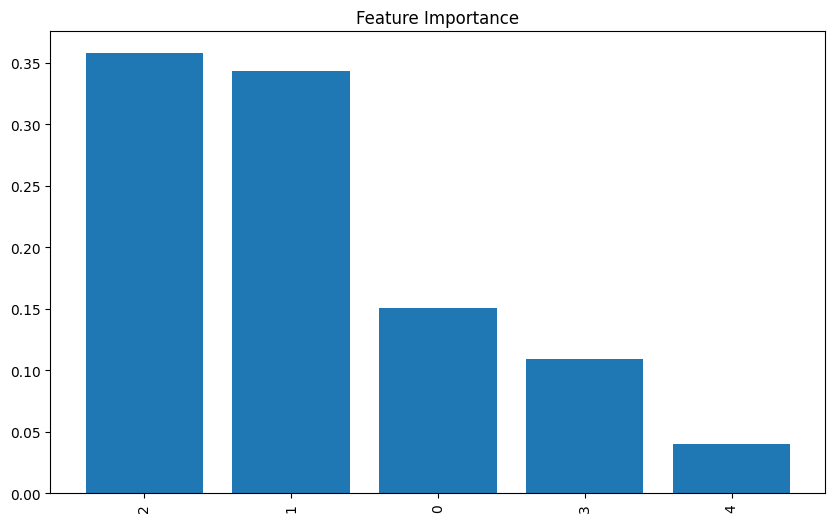

In [13]:
importances = clf_pca.feature_importances_

index = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[index], align="center")
plt.xticks(range(len(importances)),index, rotation=90)
plt.show()

Loaded 50 subjects
Creating features matrix


100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


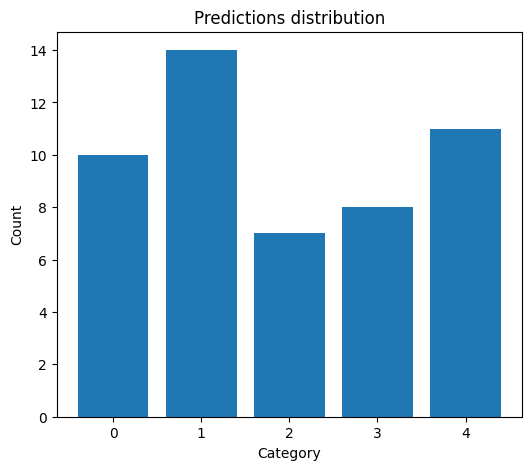

Submission file submission.csv created


In [15]:
submission(clf_pca, "submission", pca=pca)